# Optimization Example for Interim Operational Capability 1

## Set up.

### Import packages.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath("../src"))

In [2]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import seaborn           as sb
import tyche             as ty

from copy            import deepcopy
from IPython.display import Image 

In [3]:
import cProfile
import timeit

## Load data.

### The data are stored in a set of tab-separated value files in a folder.

In [4]:
designs = ty.Designs("data")

In [5]:
investments = ty.Investments("data")

### Compile the production and metric functions for each technology in the dataset.

In [6]:
designs.compile()

## Evaluate the tranches of investments.

In [7]:
tranche_results = investments.evaluate_tranches(designs, sample_count=250)

### Examine the results of investments in tranches.

In [8]:
tranche_results.summary

Value          Units
Category   Tranche      Sample Index                                 
CIGS       CIGS 0       1      Capital       -0.857107         Δ$/Wdc
                               Efficiency     0.237653          %/100
                               GHG           -0.000449  ΔgCO2e/system
                               Hazardous      0.049102          g/kWh
                               LCOE          -0.049763         Δ$/kWh
...                                                ...            ...
Soft Costs Soft Costs 2 250    Hazardous      0.254229          g/kWh
                               LCOE           0.013220         Δ$/kWh
                               Lifetime      25.000807             yr
                               Strategic      0.000000          g/kWh
                               Yield       1278.357185          hr/yr

[48000 rows x 2 columns]

### Join those results to investment levels.

In [9]:
results = investments.tranches.join(tranche_results.summary)
results

Amount Notes  \
Category   Tranche      Scenario     Sample Index                         
CIGS       CIGS 0       CIGS 0       1      Capital           0.0         
                                            Efficiency        0.0         
                                            GHG               0.0         
                                            Hazardous         0.0         
                                            LCOE              0.0         
...                                                           ...   ...   
Soft Costs Soft Costs 2 Soft Costs 2 250    Hazardous   5000000.0         
                                            LCOE        5000000.0         
                                            Lifetime    5000000.0         
                                            Strategic   5000000.0         
                                            Yield       5000000.0         

                                                              Value  \
Category   Tranche      Scenario     Sample Index                     
CIGS       CIGS 0       CIGS 0       1      Capital       -0.857107   
                                            Efficiency     0.237653   
                                            GHG           -0.000449   
                                            Hazardous      0.049102   
                                            LCOE          -0.049763   
...                                                             ...   
Soft Costs Soft Costs 2 Soft Costs 2 250    Hazardous      0.254229   
                                            LCOE           0.013220   
                                            Lifetime      25.000807   
                                            Strategic      0.000000   
                                            Yield       1278.357185   

                                                                Units  
Category   Tranche      Scenario     Sample Index                      
CIGS       CIGS 0       CIGS 0       1      Capital            Δ$/Wdc  
                                            Efficiency          %/100  
                                            GHG         ΔgCO2e/system  
                                            Hazardous           g/kWh  
                                            LCOE               Δ$/kWh  
...                                                               ...  
Soft Costs Soft Costs 2 Soft Costs 2 250    Hazardous           g/kWh  
                                            LCOE               Δ$/kWh  
                                            Lifetime               yr  
                                            Strategic           g/kWh  
                                            Yield               hr/yr  

[48000 rows x 4 columns]

#### Plot the result of investment in each category upon each metric.

##### Individual observations:

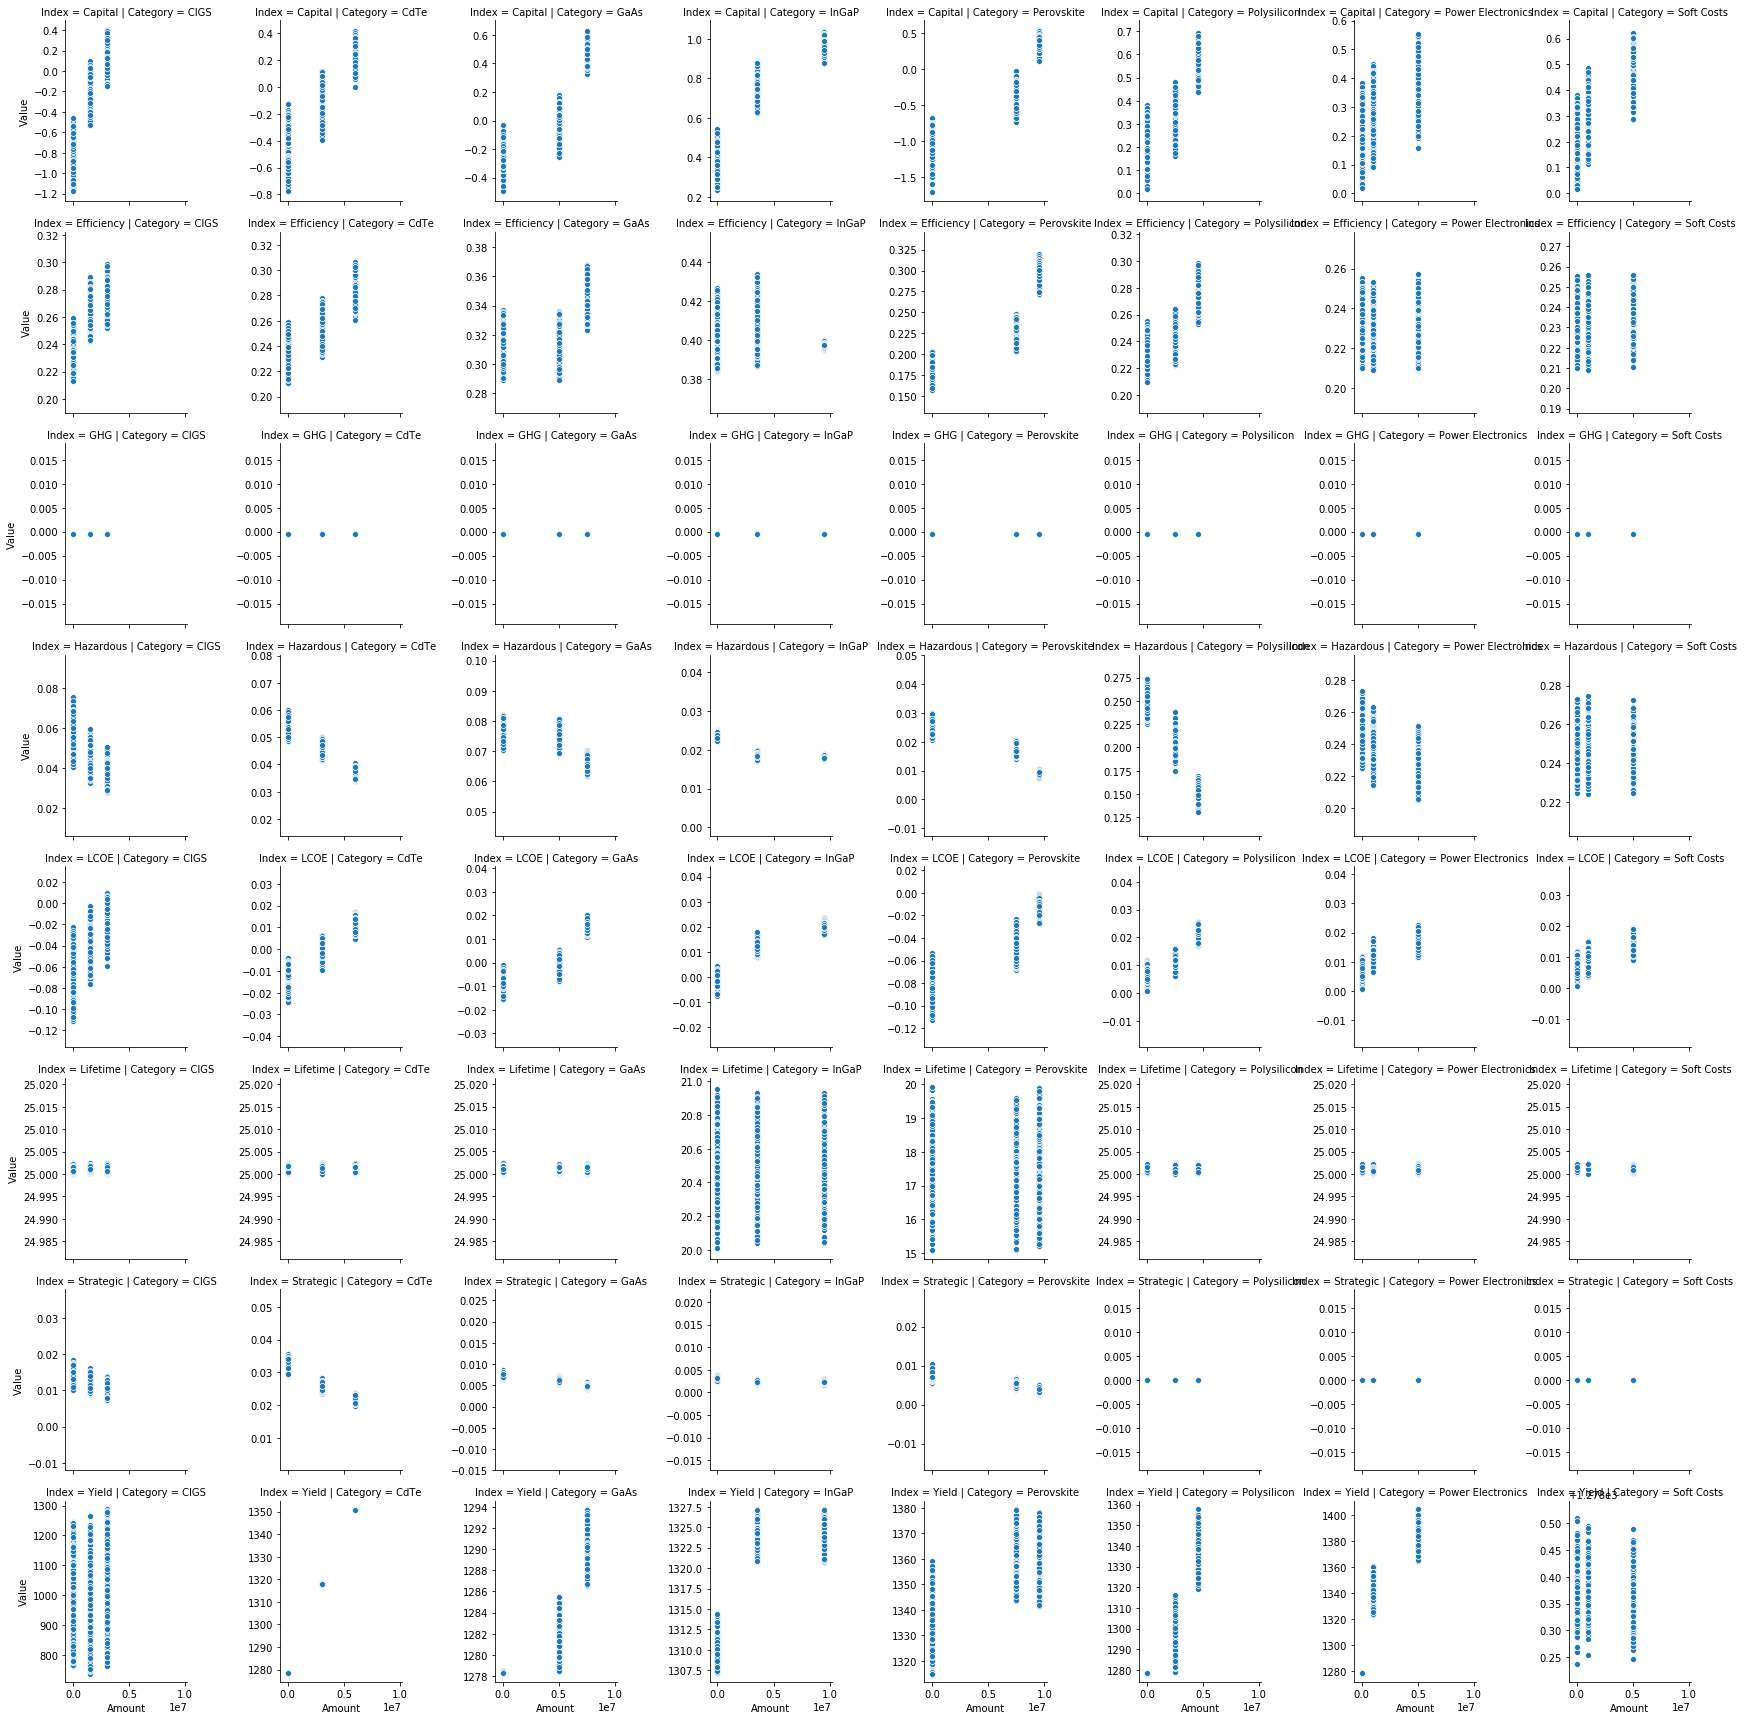

In [10]:
g = sb.FacetGrid(results.reset_index(), col="Category",  row="Index", sharey=False)
g.map(sb.scatterplot, "Amount", "Value")

##### Quantiles:

/nix/store/2hqyq1p29z76wvh920r43a63sy9n1cag-python3-3.7.6-env/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


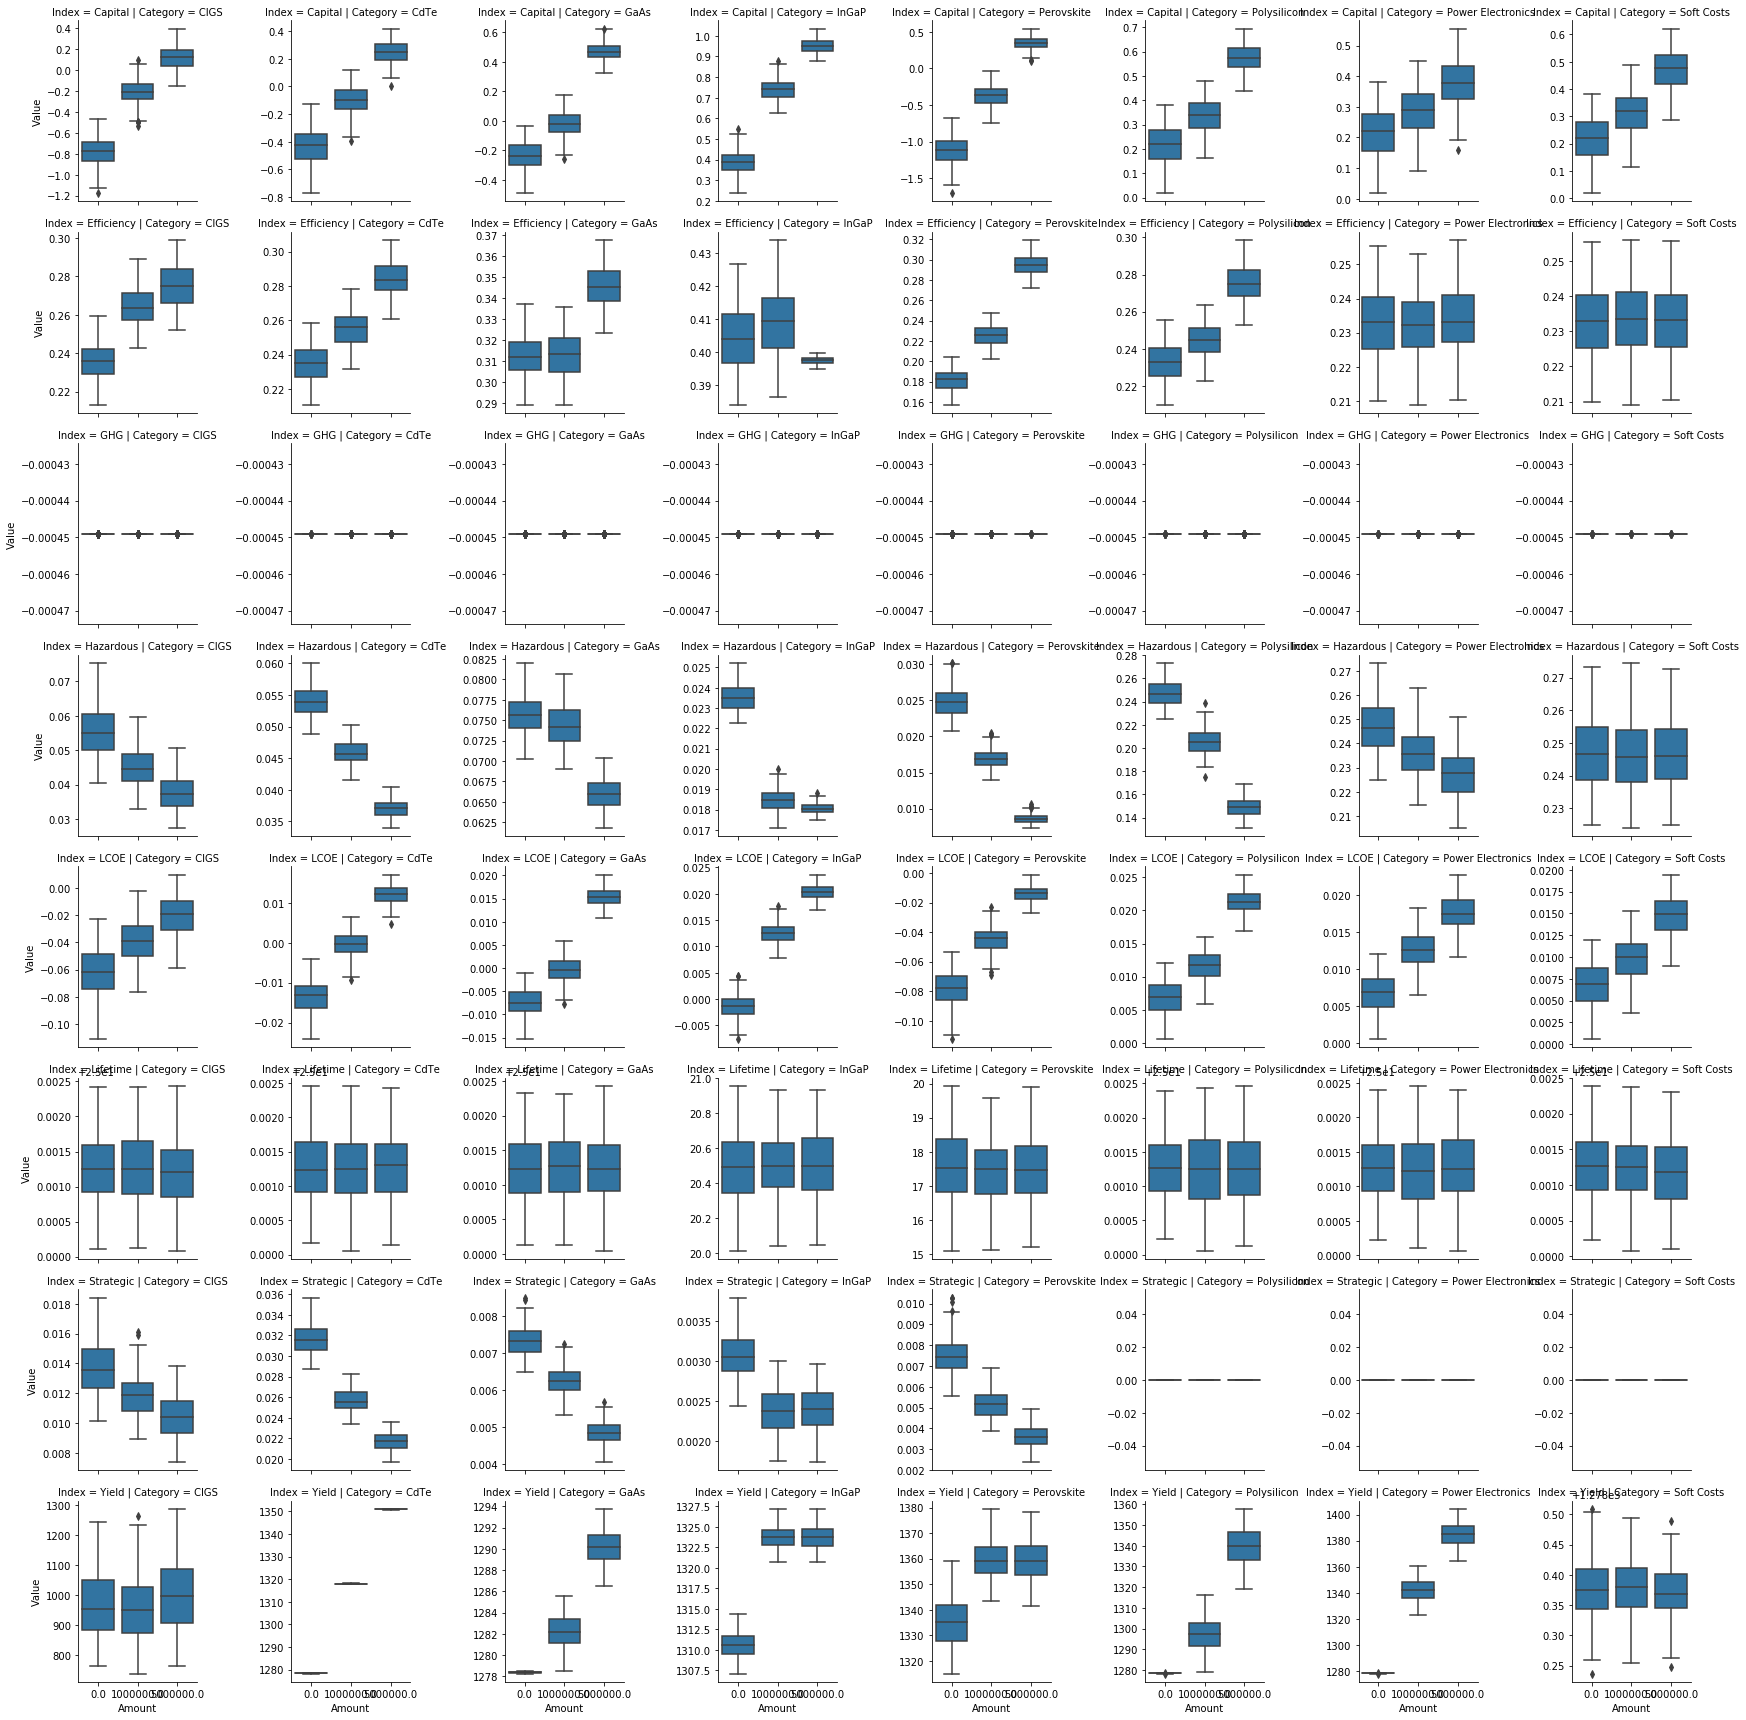

In [11]:
g = sb.FacetGrid(results.reset_index(), col="Category",  row="Index", sharey=False)
g.map(sb.boxplot, "Amount", "Value")

## Create an evaluator to interpolate investments.

In [10]:
evaluator = ty.Evaluator(investments.tranches, tranche_results.summary)

### Maximum investment amounts, by category.

In [11]:
evaluator.max_amount

,Amount
Category,
CIGS,3000000.0
CdTe,6000000.0
GaAs,7500000.0
InGaP,9500000.0
Perovskite,9500000.0
Polysilicon,4500000.0
Power Electronics,5000000.0
Soft Costs,5000000.0


### Range of metrics.

In [12]:
evaluator.min_metric.rename(columns = {"Value" : "Minimum"}).join(
    evaluator.max_metric.rename(columns = {"Value" : "Maximum"})
)

,Minimum,Maximum
Index,,
Capital,-3.821945,4.864038
Efficiency,1.882662,2.532484
GHG,-0.003592,-0.003592
Hazardous,0.706210,1.094235
LCOE,-0.275077,0.141456
Lifetime,185.102672,190.772557
Strategic,0.035287,0.076792
Yield,9753.485645,10712.107257


### All combinations ("corners") of the funding levels, in a semi-long data format.

In [13]:
evaluator.evaluate_corners_semilong()

Index                         Capital  Efficiency       GHG  Hazardous  \
Category          Amount                                                 
CIGS              0.0       -0.798772    0.234586 -0.000449   0.055476   
                  1500000.0 -0.226068    0.263845 -0.000449   0.044244   
                  3000000.0  0.131185    0.275440 -0.000449   0.037759   
CdTe              0.0       -0.434545    0.234669 -0.000449   0.054092   
                  3000000.0 -0.095380    0.255495 -0.000449   0.045785   
                  6000000.0  0.243743    0.284127 -0.000449   0.037046   
GaAs              0.0       -0.239845    0.312488 -0.000449   0.075682   
                  5000000.0 -0.020012    0.312775 -0.000449   0.074376   
                  7500000.0  0.465689    0.344314 -0.000449   0.066230   
InGaP             0.0        0.387136    0.404559 -0.000449   0.023485   
                  3500000.0  0.735613    0.410214 -0.000449   0.018392   
                  9500000.0  0.950795    0.397468 -0.000449   0.018098   
Perovskite        0.0       -1.151316    0.180250 -0.000449   0.025110   
                  7500000.0 -0.372307    0.225836 -0.000449   0.016771   
                  9500000.0  0.353673    0.295640 -0.000449   0.008586   
Polysilicon       0.0        0.211310    0.232246 -0.000449   0.247661   
                  2500000.0  0.341313    0.245819 -0.000449   0.204119   
                  4500000.0  0.571237    0.274397 -0.000449   0.149581   
Power Electronics 0.0        0.211310    0.232246 -0.000449   0.247661   
                  1000000.0  0.295069    0.233396 -0.000449   0.234677   
                  5000000.0  0.365846    0.232170 -0.000449   0.228655   
Soft Costs        0.0        0.211310    0.232246 -0.000449   0.247661   
                  1000000.0  0.302232    0.232718 -0.000449   0.247115   
                  5000000.0  0.471167    0.233358 -0.000449   0.246480   

Index                            LCOE   Lifetime  Strategic        Yield  
Category          Amount                                                  
CIGS              0.0       -0.062837  25.001209   0.013764   966.055528  
                  1500000.0 -0.038131  25.001285   0.011613   972.652124  
                  3000000.0 -0.020834  25.001192   0.010512   996.249287  
CdTe              0.0       -0.013580  25.001303   0.031673  1278.375978  
                  3000000.0 -0.000268  25.001195   0.025592  1318.049054  
                  6000000.0  0.011892  25.001232   0.021697  1350.946224  
GaAs              0.0       -0.007489  25.001257   0.007280  1278.373847  
                  5000000.0 -0.000348  25.001242   0.006261  1282.227251  
                  7500000.0  0.015245  25.001294   0.004897  1290.155786  
InGaP             0.0       -0.001376  20.488566   0.003077  1310.642004  
                  3500000.0  0.012477  20.530011   0.002391  1323.563241  
                  9500000.0  0.020302  20.494004   0.002374  1323.832289  
Perovskite        0.0       -0.080144  17.492678   0.007644  1335.926718  
                  7500000.0 -0.043677  17.611340   0.005167  1358.255368  
                  9500000.0 -0.013944  17.459756   0.003562  1359.433203  
Polysilicon       0.0        0.006627  25.001254   0.000000  1278.376204  
                  2500000.0  0.011855  25.001226   0.000000  1298.200335  
                  4500000.0  0.021014  25.001202   0.000000  1339.194438  
Power Electronics 0.0        0.006627  25.001254   0.000000  1278.376204  
                  1000000.0  0.012954  25.001284   0.000000  1342.631250  
                  5000000.0  0.017264  25.001230   0.000000  1385.093485  
Soft Costs        0.0        0.006627  25.001254   0.000000  1278.376204  
                  1000000.0  0.009472  25.001262   0.000000  1278.378814  
                  5000000.0  0.014757  25.001231   0.000000  1278.371879

### All combinations ("corners") of the funding levels, in a wide data format.

In [14]:
evaluator.evaluate_corners_wide()

Index                                                                                         Capital  \
CIGS      CdTe      GaAs      InGaP     Perovskite Polysilicon Power Electronics Soft Costs             
0.0       0.0       0.0       0.0       0.0        0.0         0.0               0.0        -1.603412   
                                                                                 1000000.0  -1.512491   
                                                                                 5000000.0  -1.343556   
                                                               1000000.0         0.0        -1.519654   
                                                                                 1000000.0  -1.428732   
...                                                                                               ...   
3000000.0 6000000.0 7500000.0 9500000.0 9500000.0  4500000.0   1000000.0         1000000.0   3.313623   
                                                                                 5000000.0   3.482558   
                                                               5000000.0         0.0         3.293478   
                                                                                 1000000.0   3.384400   
                                                                                 5000000.0   3.553335   

Index                                                                                        Efficiency  \
CIGS      CdTe      GaAs      InGaP     Perovskite Polysilicon Power Electronics Soft Costs               
0.0       0.0       0.0       0.0       0.0        0.0         0.0               0.0           2.063288   
                                                                                 1000000.0     2.063761   
                                                                                 5000000.0     2.064401   
                                                               1000000.0         0.0           2.064439   
                                                                                 1000000.0     2.064911   
...                                                                                                 ...   
3000000.0 6000000.0 7500000.0 9500000.0 9500000.0  4500000.0   1000000.0         1000000.0     2.337501   
                                                                                 5000000.0     2.338141   
                                                               5000000.0         0.0           2.335802   
                                                                                 1000000.0     2.336275   
                                                                                 5000000.0     2.336915   

Index                                                                                             GHG  \
CIGS      CdTe      GaAs      InGaP     Perovskite Polysilicon Power Electronics Soft Costs             
0.0       0.0       0.0       0.0       0.0        0.0         0.0               0.0        -0.003592   
                                                                                 1000000.0  -0.003592   
                                                                                 5000000.0  -0.003592   
                                                               1000000.0         0.0        -0.003592   
                                                                                 1000000.0  -0.003592   
...                                                                                               ...   
3000000.0 6000000.0 7500000.0 9500000.0 9500000.0  4500000.0   1000000.0         1000000.0  -0.003592   
                                                                                 5000000.0  -0.003592   
                                                               5000000.0         0.0        -0.003592   
                                                                                 100000

## ε-Constraint multiobjective optimization

### Create an optimizer.

In [15]:
optimizer = ty.EpsilonConstraintOptimizer(evaluator)

### Optimize on a single metric.

In [21]:
evaluator.max_amount

,Amount
Category,
CIGS,3000000.0
CdTe,6000000.0
GaAs,7500000.0
InGaP,9500000.0
Perovskite,9500000.0
Polysilicon,4500000.0
Power Electronics,5000000.0
Soft Costs,5000000.0


In [22]:
evaluator.min_metric

,Value
Index,
Capital,-3.868426
Efficiency,1.875828
GHG,-0.003592
Hazardous,0.707592
LCOE,-0.274782
Lifetime,185.220877
Strategic,0.035916
Yield,9749.207663


In [23]:
optimum = optimizer.maximize_slsqp(
    "LCOE",
    max_amount = evaluator.max_amount.Amount / 2,
    min_metric = evaluator.min_metric.Value,
    verbose = 2,
)
optimum.exit_message

  NIT    FC           OBJFUN            GNORM
    1    10     1.329850E-01     2.007470E-02
    2    20     1.325820E-01     2.007470E-02
    3    30     1.305670E-01     2.007470E-02
    4    40     1.204922E-01     2.007470E-02
    5    50     1.015416E-01     1.477840E-02
    6    60     1.014028E-01     1.477840E-02
    7    70     1.007087E-01     1.477840E-02
    8    80     9.723812E-02     1.477840E-02
    9    90     8.441095E-02     1.360886E-02
   10   100     7.760736E-02     1.345499E-02
   11   110     7.739710E-02     1.345499E-02
   12   120     7.634581E-02     1.345499E-02
   13   130     7.108939E-02     1.345499E-02
   14   140     6.277017E-02     1.334999E-02
   15   150     6.261433E-02     1.334999E-02
   16   160     6.183510E-02     1.334999E-02
   17   170     5.793898E-02     1.334999E-02
   18   180     5.013293E-02     1.281113E-02
   19   190     5.011463E-02     1.281113E-02
   20   200     5.002317E-02     1.281113E-02
   21   210     4.956584E-02     1

'Optimization terminated successfully.'

#### Optimal investment amounts:

In [17]:
optimum.amounts

Category
CIGS                 1500000.0
CdTe                 3000000.0
GaAs                 3750000.0
InGaP                4750000.0
Perovskite           4750000.0
Polysilicon          2250000.0
Power Electronics    2500000.0
Soft Costs           2500000.0
Name: Amount, dtype: float64

#### Values of metrics at optimal investment:

In [18]:
optimum.metrics

Index
Capital           0.762161
Efficiency        2.160155
GHG              -0.003592
Hazardous         0.890750
LCOE             -0.045922
Lifetime        188.019373
Strategic         0.052291
Yield         10175.043505
Name: Value, dtype: float64

### Time the code.

In [19]:
timeit.timeit(lambda: optimizer.maximize_slsqp("LCOE", max_amount = evaluator.max_amount.Amount), number=1)

6.161067922832444

### Profile the code to see where it is slow.

In [20]:
cProfile.run('optimizer.maximize_slsqp("LCOE", max_amount = evaluator.max_amount.Amount)')

         13290364 function calls (13133588 primitive calls) in 9.334 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(any)
       34    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(append)
       66    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argsort)
      342    0.000    0.000    0.005    0.000 <__array_function__ internals>:2(array_equal)
       69    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(asfarray)
      103    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(atleast_1d)
       73    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(bincount)
      349    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(can_cast)
        2    0.000  

        1    0.000    0.000    0.000    0.000 frame.py:4573(<listcomp>)
        7    0.000    0.000    0.000    0.000 frame.py:515(axes)
      341    0.000    0.000    0.002    0.000 frame.py:532(shape)
        2    0.000    0.000    0.005    0.003 frame.py:5736(groupby)
      341    0.001    0.000    6.734    0.020 frame.py:6731(apply)
      341    0.002    0.000    0.547    0.002 frame.py:7088(join)
      341    0.003    0.000    0.545    0.002 frame.py:7212(_join_compat)
      341    0.000    0.000    0.000    0.000 frame.py:8084(_get_agg_axis)
    21824    0.004    0.000    0.004    0.000 fromnumeric.py:1270(_searchsorted_dispatcher)
    21824    0.021    0.000    0.092    0.000 fromnumeric.py:1274(searchsorted)
       34    0.000    0.000    0.000    0.000 fromnumeric.py:1689(_ravel_dispatcher)
       34    0.000    0.000    0.000    0.000 fromnumeric.py:1693(ravel)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2017(_clip_dispatcher)
        2    0.000    0.000    0

      342    0.001    0.000    0.016    0.000 ops.py:890(slabels)
      342    0.000    0.000    0.008    0.000 ops.py:895(sort_idx)
     3069    0.009    0.000    0.508    0.000 ops.py:900(__iter__)
      343    0.001    0.000    0.063    0.000 ops.py:913(_get_sorted_data)
     2728    0.002    0.000    0.419    0.000 ops.py:921(_chop)
        1    0.000    0.000    0.016    0.016 ops.py:926(fast_apply)
      342    0.001    0.000    0.001    0.000 ops.py:940(get_splitter)
        1    0.000    0.000    0.000    0.000 optimize.py:139(_check_unknown_options)
        2    0.000    0.000    0.000    0.000 optimize.py:320(wrap_function)
   374/68    0.001    0.000    9.267    0.136 optimize.py:325(function_wrapper)
       64    0.000    0.000    0.000    0.000 polyint.py:105(_reshape_yi)
       64    0.000    0.000    0.002    0.000 polyint.py:113(_set_yi)
       64    0.000    0.000    0.000    0.000 polyint.py:133(_set_dtype)
       64    0.000    0.000    0.002    0.000 polyint.py:55(_

In [21]:
evaluate = evaluator.make_statistic_evaluator()
cProfile.run('evaluate(evaluator.max_amount.Amount)')

         38721 function calls (38270 primitive calls) in 0.035 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(array_equal)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(can_cast)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(cumsum)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(min_scalar_type)
      128    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(ndim)
        9    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(putmask)
       64    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(searchsorted)
        9    0.00

        1    0.000    0.000    0.002    0.002 merge.py:639(get_result)
        1    0.000    0.000    0.000    0.000 merge.py:718(_maybe_restore_index_levels)
        1    0.000    0.000    0.000    0.000 merge.py:753(_maybe_add_join_keys)
        1    0.000    0.000    0.000    0.000 merge.py:844(_get_join_info)
        1    0.000    0.000    0.000    0.000 merge.py:929(_get_merge_keys)
       13    0.000    0.000    0.001    0.000 missing.py:132(_isna_new)
       10    0.000    0.000    0.000    0.000 missing.py:225(_isna_ndarraylike)
        2    0.000    0.000    0.000    0.000 missing.py:402(array_equivalent)
       13    0.000    0.000    0.001    0.000 missing.py:49(isna)
       24    0.000    0.000    0.000    0.000 multi.py:1175(__len__)
       29    0.000    0.000    0.000    0.000 multi.py:1178(_get_names)
       10    0.000    0.000    0.000    0.000 multi.py:1181(_set_names)
        1    0.000    0.000    0.001    0.001 multi.py:1243(_get_grouper_for_level)
        1    0.